<h4>Transfer Learning using Detectron2 for Object Detection of Persons, Cars, and Traffic Lights



     In this project, I used the Detectron2 library and transfer learning to train a model for detecting persons, cars, and traffic lights in a custom dataset of street images taken in the Haifa area around the University campus.

     This project demonstrates the efficacy of transfer learning and the Detectron2 library for object detection tasks and its potential to be applied to real-world scenarios. which I will continue working on in Final Project 1 & 2

     Submitted by : Muhammad Haj Ali 206539991

Due to the trained model size, I have uploaded the project to Google Drive, and the link to download the file is provided here: https://drive.google.com/drive/folders/1fFCWo8jxAt9Gmm4GrkIWUxMjg4008DNE?usp=sharing.


The project is implemented in the Jupyter Notebook format, and the code is available in the file TRAINandINFERENCE_EX3_206539991.ipynb. Additionally, I have included a compiled ipynb file and an HTML version of the project for easy viewing.

###**Installing Detectron2 / needs Python 3.9.13 & Microsoft Visual C++ 14.0  + a graphics card**


In [ ]:
# !pip install pyyaml==5.1
# !pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install cython
# !pip install opencv-python
# !pip install -e detectron2
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

In [1]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
import os
os.chdir('detectron2/')
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

 read JSON files containing annotations for images and convert them into a format that can be used as input to our model.

In [2]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        print(filename)
        record["file_name"] = filename
        record["height"] = 800
        record["width"] = 800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

register a custom dataset for training a computer vision model and set its metadata, including the list of object categories.

    please update the data_path to contain the path to data file "/detectron2/data/"

In [3]:
classes = ['traffic light','person','car']

#update here
data_path = 'C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "categ_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("categ_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("categ_")



Set the hyperparameters to the model for Instance Segmentation Model and preload the already trained mask_rcnn model

    note: The number of iterations is set to 500, you can change it on stronger computers

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("categ_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

create a directory for storing the output of the model training process and to instantiate a DefaultTrainer object to train our model

In [5]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[02/27 19:41:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

In [6]:
trainer.train()

[02/27 19:41:19 d2.engine.train_loop]: Starting training from iteration 0
[02/27 19:41:36 d2.utils.events]:  eta: 0:05:35  iter: 19  total_loss: 2.515  loss_cls: 1.383  loss_box_reg: 0.3347  loss_mask: 0.6892  loss_rpn_cls: 0.05484  loss_rpn_loc: 0.03513  time: 0.7214  last_time: 0.7032  data_time: 0.1135  last_data_time: 0.0081   lr: 9.7405e-06  max_mem: 2230M
[02/27 19:41:52 d2.utils.events]:  eta: 0:05:39  iter: 39  total_loss: 2.465  loss_cls: 1.205  loss_box_reg: 0.392  loss_mask: 0.6812  loss_rpn_cls: 0.07239  loss_rpn_loc: 0.06621  time: 0.7557  last_time: 0.8891  data_time: 0.0057  last_data_time: 0.0016   lr: 1.9731e-05  max_mem: 2283M
[02/27 19:42:07 d2.utils.events]:  eta: 0:05:25  iter: 59  total_loss: 2.026  loss_cls: 0.9046  loss_box_reg: 0.388  loss_mask: 0.6636  loss_rpn_cls: 0.04822  loss_rpn_loc: 0.03306  time: 0.7557  last_time: 0.7108  data_time: 0.0016  last_data_time: 0.0017   lr: 2.972e-05  max_mem: 2283M
[02/27 19:42:24 d2.utils.events]:  eta: 0:05:14  iter: 79 

###**Inference using the Trained Model**
and setting the threshold to 0.5, meaning any detections with the confidence below 0.5 will not be shown

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("street_test", )
predictor = DefaultPredictor(cfg)

[02/27 19:47:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


In [8]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752296331.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752514251.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752547155.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752582059.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752628763.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752649065.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752664967.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752683369.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752700471.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/latest/detectron2/data/test\Resizer_167750752720573.jpg
C:/Users/Home/OneDrive/Desktop/YoloTest/

#sometimes the code below doesn't run from the first time, just rerun it

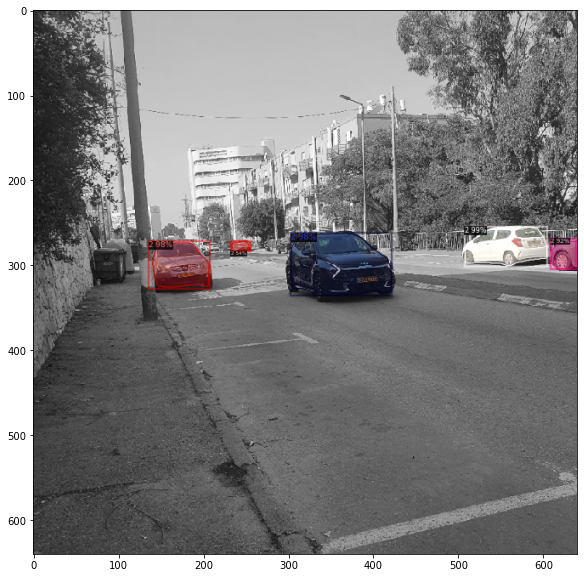

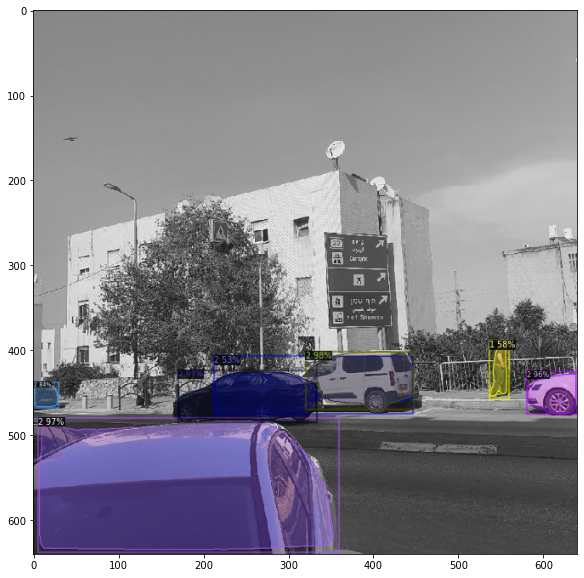

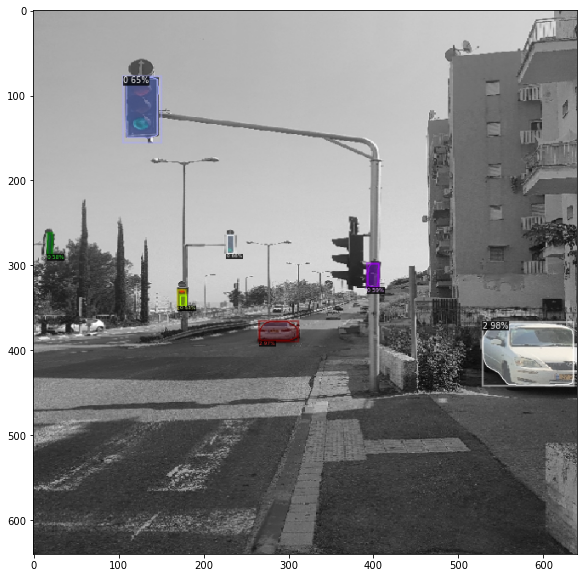

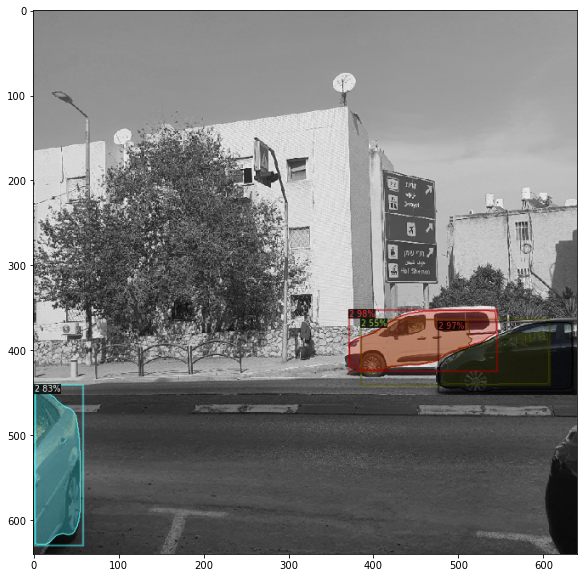

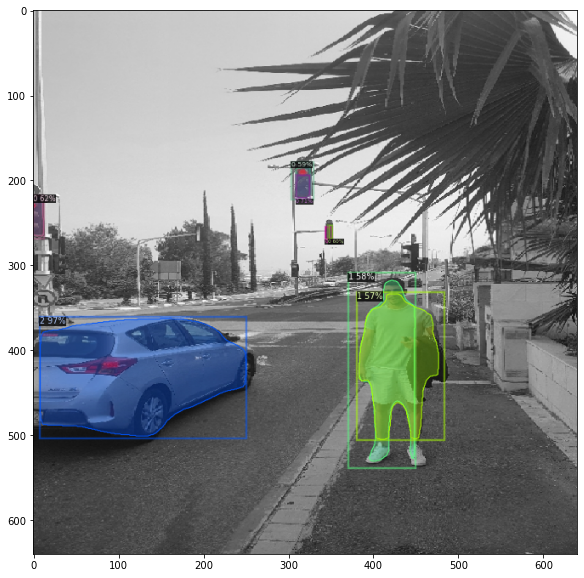

In [16]:
for d in random.sample(test_dataset_dicts, 5):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()